In [1]:
%matplotlib inline

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)

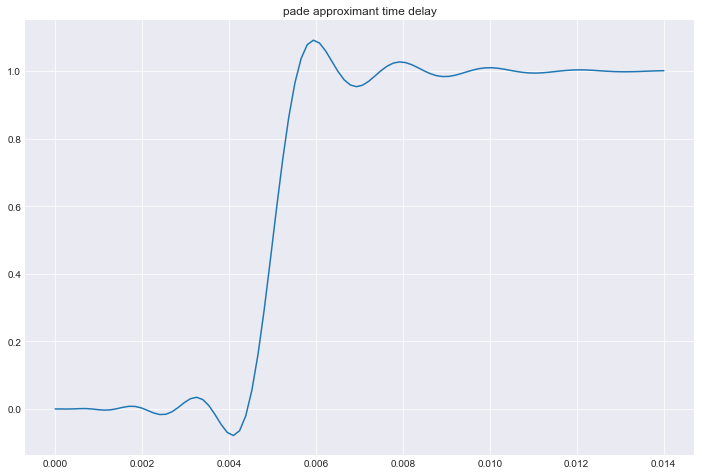

In [2]:
import control
num, den = control.pade(0.005, 11, 7)
d = scipy.signal.TransferFunction(num, den)
t, y = scipy.signal.step(d)
plt.close('all')
fig, ax = plt.subplots()
ax.plot(t, y)
ax.set_title('pade approximant time delay')
plt.show()

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


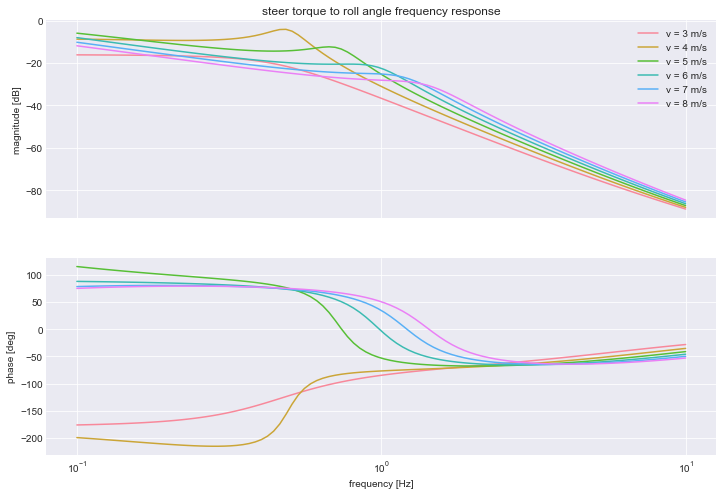

In [3]:
def benchmark_tf(velocity):
    v, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), velocity)
    inputs = 2
    outputs = 4
    
    C = np.eye(4)
    D = np.zeros((4, 2))
    
    tf_v = []
    for k in range(len(v)):
        tf = []
        for i in range(inputs):
            Bi = B[k][:, [i]]
            for j in range(outputs):
                Cj = C[[j], :]
                Dj = D[[j], [i]]
                
                sysij = scipy.signal.StateSpace(A[k], Bi, Cj, Dj)
                tf.append(scipy.signal.TransferFunction(sysij))
        tf = np.array(tf).reshape((inputs, outputs))
        tf_v.append(tf)
    return v, np.array(tf_v)

def delay_tf(tf, delay):
    num, den = control.pade(delay, 11, 7)
    d = control.tf(num, den)
    
    d_tf = d*control.tf(np.squeeze(tf.num), np.squeeze(tf.den))
    return scipy.signal.TransferFunction(np.squeeze(d_tf.num),
                                         np.squeeze(d_tf.den))

def plot_tf(tf_v, tf_index, velocity, time_delay=0):
    assert len(velocity) == len(tf_v)
    
    color = sns.husl_palette(len(velocity), l=0.7)
    fig, ax = plt.subplots(2, 1, sharex=True)
    
    for v, tf_matrix, c in zip(velocity, tf_v, color):
        tf = tf_matrix[tf_index]
        if time_delay != 0:
            tf = delay_tf(tf, time_delay)
            
        w, magnitude, phase = tf.bode(w=2*np.pi*np.logspace(-1, 1, 100))
        if phase[-1] > 180:
            phase -= 360
        freq = w / (2*np.pi)
        ax[0].semilogx(freq, magnitude, color=c,
                       label='v = {} m/s'.format(v))
        ax[1].semilogx(freq, phase, color=c)
        
    ax[0].legend()
    ax[0].set_ylabel('magnitude [dB]')
    ax[1].set_ylabel('phase [deg]')
    ax[1].set_xlabel('frequency [Hz]')
    return fig, ax
    
plt.close('all')

v, tf_v = benchmark_tf([3, 4, 5, 6, 7, 8])
fig, ax = plot_tf(tf_v, (1, 0), v)
ax[0].set_title('steer torque to roll angle frequency response')
#fig, ax = plot_tf(tf_v, (1, 0), v, 0.005)
#ax[0].set_title('steer torque to roll angle frequency response')

plt.show()